In [1]:
from pyigrf.igrf import igrf
import numpy as np
import datetime

In [2]:
# Geodetic to Geocentric coordinates transformation
# WGS84 constants
# reference:
# http://earth-info.nga.mil/GandG/publications/tr8350.2/wgs84fin.pdf
a_WGS=6378.137
flatness = 1./298.257223563  # flatenning
b_WGS=a_WGS*(1.-flatness)    # WGS polar radius (semi-minor axis) in km
eccentricity=np.sqrt(a_WGS**2-b_WGS**2)/a_WGS

def geod2geoc(lon,geodlat,h):
    # returns geocentric xyz coordinates (ECEF) in km of a target with
    # latitude       geodlat (rad) --- geodetic
    # longitude      lon (rad)
    # height         h (km above local ellipsoid)
    n=a_WGS / np.sqrt(1.-flatness*(2.-flatness) * np.sin(geodlat)**2.)
    # cartesian geocentric coordinates wrt Greenwich
    x=(n+h)*np.cos(geodlat)*np.cos(lon)
    y=(n+h)*np.cos(geodlat)*np.sin(lon)
    z=(n*(1.-eccentricity**2.)+h)*np.sin(geodlat)   
    
    p   = np.sqrt(x**2. + y**2.)
    geoclat = np.arctan2(z,p)        # geocentric latitude (theta)
    
    return x,y,z,geoclat

In [3]:
# instantiating IGRF:
igrf0 = igrf(verbose=True)

Using coefficients file: igrf13coeffs.txt
max_n is 13
Last Epoch year is: 2020.0
secular variation: 2020-25


# Inclination and Declination maps on Feb10, 2020

In [4]:
%pylab inline
try:
    import cartopy
    usecartopy = True
except:
    print("Warning! Cartopy not installed. Proceeding without it.")
    usecartopy = False # Allow us to plot the maps even when cartopy is not installed

Populating the interactive namespace from numpy and matplotlib


In [5]:
deg = 180/np.pi
dt0 = datetime.datetime(2020,2,10)
yeardays = datetime.datetime(dt0.year,12,31).timetuple().tm_yday
doy = dt0.timetuple().tm_yday
year = dt0.year + doy/yeardays

longs = np.arange(-179,179,1)
lats = np.arange(-89,89,1)
ht=0
inclination = np.empty((lats.size,longs.size),dtype = np.float64) * np.nan
declination = np.empty((lats.size,longs.size),dtype = np.float64) * np.nan
gclats = []
for i,geod_lat in enumerate(lats):
    for j,lon in enumerate(longs):
        x,y,z,lat = geod2geoc(lon/deg, geod_lat/deg, ht)
        gclats += [lat*deg]
        [Bn,Be,Bd,B] = igrf0.igrf_B(year, ht, lon, lat*deg)
        inclination[i,j] = np.arcsin(Bd/B)*deg
        declination[i,j] = np.arctan2(Be,Bn)*deg

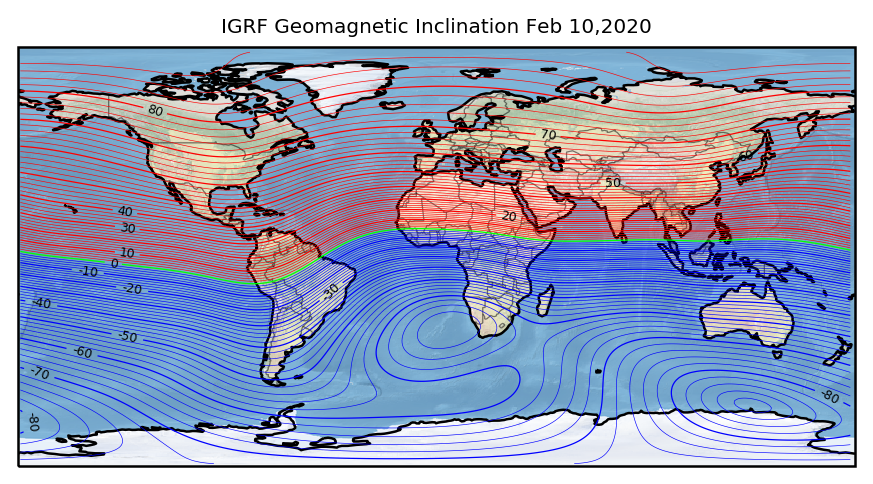

In [6]:
if usecartopy:
    import cartopy.crs as ccrs
    import cartopy.feature as cf
    fig,ax = plt.subplots(dpi=180,subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()
    ax.add_feature(cf.BORDERS, linestyle='-', alpha=.5, linewidth=0.5)
    ax.stock_img()
    ax.coastlines()
else:
    fig,ax = plt.subplots(dpi=180)

levels = np.arange(-90,90,2)
colors = ["red" if x>0 else ("blue" if x<0 else "lime") for x in levels]
linewidths = [0.5 if x%10==0 else 0.25 for x in levels]
CS = ax.contour(longs,lats,inclination, levels=levels, colors=colors, linewidths=linewidths, linestyles="-")
ax.clabel(CS,np.arange(-90,90,10), inline=1, fontsize=5,fmt="%g",colors='k')
ax.set_title(dt0.strftime("IGRF Geomagnetic Inclination %b %d,%Y"),fontsize=8);

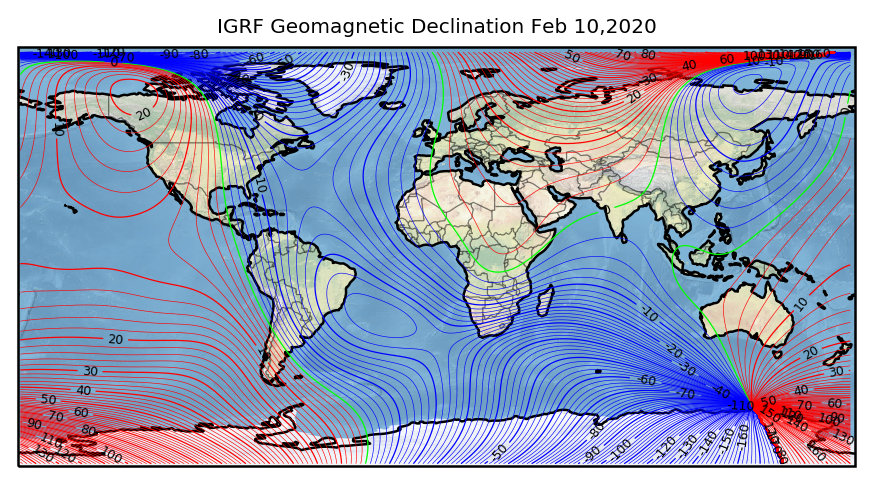

In [7]:
if usecartopy:
    import cartopy.crs as ccrs
    import cartopy.feature as cf
    fig,ax = plt.subplots(dpi=180,subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()
    ax.add_feature(cf.BORDERS, linestyle='-', alpha=.5, linewidth=0.5)
    ax.stock_img()
    ax.coastlines()
else:
    fig,ax = plt.subplots(dpi=180)
levels = np.arange(-180,180,2)
colors = ["red" if x>0 else ("blue" if x<0 else "lime") for x in levels]
linewidths = [0.5 if x%10==0 else 0.25 for x in levels]
CS = ax.contour(longs,lats,declination, levels=levels, colors=colors, linewidths=linewidths, linestyles="-")
ax.clabel(CS,np.arange(-180,180,10), inline=1, fontsize=5,fmt="%g",colors='k')
ax.set_title(dt0.strftime("IGRF Geomagnetic Declination %b %d,%Y"),fontsize=8);